In [1]:
#Bowerbird null model (all males are guarders)

#Key
#Notes- Paramters contain underscores, while functions don't
#SB: Stay at bower
#FG: Foraging
#a=-1: denotes a staying at bower action on ticket
#a=-2: denotes a foraging action on ticket
#a=-3: denotes a female visiting action on a ticket
#networkwriter: generates network where everybird is connected
#addtotimeline: adds tickets to timeline
#travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
#if the relationship between distance and travel preference is linear
#improb: The probability of traveling improb_distance or less
#improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel
#lamb: lambda calculated by solving improb=1-numpy.exp(-lamb*improb_distance)
#bower_states: options are 1(bower intact) and 0 (bower destroyed-will never be the case when all guarders)
#male_states: options are 1 (male present at bower) and 0 (male absent from bower)
#fitness_states: keeps track of number of matings a given male has had
#t: time
#nodes: total number of male bowerbirds in the network
#node_dist: the node by nde matrix with distances between each node
#node_graph: matrix with individuals 1 through nodes numbered by going through each row




import math
import random
import numpy as numpy
import matplotlib.pyplot as plt


# makes a ticket
def ticketgenerator(tau,t, o, a):
    ticket={
        'tau': tau,
        'time': t,
        'owner': o,
        'action': a,
    }
    return ticket;

#writes the edges to a network of n birds where everyone is connected to everyone else 
def networkwriter(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network


# function for determining the next time based on our rate parameters
def nexttau(action):
    x=-1
    while x<=0:
        switcher = {
            -1: numpy.random.normal(loc=.1583, scale=.09755, size=1)[0], #choose when to leave bower (generate a tau for bower stay)
            -2: numpy.random.gamma(shape=1.5, scale=5, size=1)[0]/60, #choose when to stop foraging (generate a tau for foraging)
            -3: numpy.random.uniform(FV_param[0], FV_param[1]) #FV_param... totally arbitrary so we should think about it
        }
        x=switcher.get(action, "invalid action")
    return x
    

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def addtotimeline(tic, timeline):
    if not timeline:
        timeline.append(tic)
    else:
        ind=len(timeline)-1
        end=0
        while (tic['time']<timeline[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
            ind=ind-1 
            if(ind<0):
                end=1
        ind=ind+1
        timeline.insert(ind, tic)
    

def SBtickethandler (SB_tic, timeline,SB_param, t_max, male_states):
    ow=SB_tic['owner'] 
    male_states[ow]=1
    t=SB_tic['time']
    FG_time=nexttau(-1)+t #We use SB_param because the time represents when the bird leaves the bower
    if FG_time<t_max:
        FG_tic=ticketgenerator(FG_time-t,FG_time,ow,-2) #-2 denotes foraging action
        addtotimeline(FG_tic,timeline)

def FGtickethandler (FG_tic, timeline,FG_param, t_max, male_states):
    ow=FG_tic['owner'] 
    male_states[ow]=0
    t=FG_tic['time']
    SB_time=nexttau(-2)+t #We use FG_param because the time represents when the bird returns to the bower
    if SB_time<t_max:
        SB_tic=ticketgenerator(SB_time-t,SB_time,ow,-1) #-1 denotes staying at bower
        addtotimeline(SB_tic,timeline)
    
def FVtickethandler (FV_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, female_preferences, travel_times, success_rate, success_times, recents_list, max_visits):
    ow=FV_tic['owner']
    t=FV_tic['time']
    r=random.random()
    if bower_states[ow]==1 and male_states[ow]==1 and r<success_rate: #if the bower is intact and the male is present
        recents_list=[]
        fitness_states[ow]=fitness_states[ow]+1 #assumption: female always mates if bower is intact and male present
        success_times.append(t)
        new_FV_ow=numpy.random.choice(list(range(nodes)))
        decider=random.random() #decide whether female will mate for a second time
        if decider<.8: #half the time she'll mate again due to predation (or for the heck of it -- PJ said 4-5 matings)
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, new_FV_ow, -3)
                addtotimeline(new_FV_tic, timeline)        
    else: #if female does not successfully mate
        recents_list.append(ow)
        if len(recents_list)==min(max_visits, nodes): 
            recents_list=[]
            print(recents_list)
            new_FV_ow=numpy.random.choice(list(range(nodes)))
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, new_FV_ow, -3)
                addtotimeline(new_FV_tic, timeline)
        else:
            new_FV_ow=-1 #just so that the code goes into the while loop the first iteration
            while(new_FV_ow in recents_list or new_FV_ow==-1):
                new_FV_ow=numpy.random.choice(list(range(nodes)), p=female_preferences[ow]) #choose a male based on preference (a function of distance)
            new_FV_time=t+travel_times[ow][new_FV_ow] #she goes directly to this male
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, new_FV_ow, -3)
                addtotimeline(new_FV_tic, timeline)
    return recents_list

#distance function
def travel(nodes,d,bird_speed):
    node_dist= numpy.array([[-1.0]*nodes]*nodes) #(dist in m)initialize a nodes-by-nodes matrix (1st nrows, 2nd ncols)
    sqrt_nodes=int(math.sqrt(nodes)) 
    node_graph=numpy.arange(nodes)
    node_mat=node_graph.reshape(sqrt_nodes,sqrt_nodes)
    for i in range(sqrt_nodes):
        for j in range (sqrt_nodes):
            n1=node_mat[i][j]
            for a in range(sqrt_nodes):
                for b in range(sqrt_nodes):
                    n2=node_mat[a][b]
                    if n1<n2:
                        d12=math.hypot((i-a)*d,abs(j-b)*d)
                        node_dist[n1][n2]=d12
                        node_dist[n2][n1]=d12
                    if n1==n2:
                        node_dist[n1][n2]=0
    travel_times=numpy.array([[0.0]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            travel_times[i][j]=node_dist[i][j]/bird_speed
    return [node_dist,travel_times, node_mat]




bird_speed=12*3600 #m/hr (12m/s)
nodes=100
d=150.0
travel_mats=travel(nodes,d,bird_speed)
node_dist=travel_mats[0]
travel_times=travel_mats[1]
#print(travel_mats[0].astype(int))
#print(travel_mats[1])




#solve for lambda 
improb=0.99
improb_distance=800
lamb=-math.log(1-improb)/improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
def female_probs(node_dist, nodes, lamb):
    female_preferences=numpy.array([[0.]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            if i!=j:
                female_preferences[i][j]=math.exp(-lamb*node_dist[i][j])        
        female_preferences[i]=female_preferences[i]/sum(female_preferences[i])
    return female_preferences

female_preferences=female_probs(travel_times, nodes, lamb)
#print(female_preferences)
#print(female_preferences[1])


In [2]:
#just a test

#Parameters:
t=0 #start at time 0
t_max=12*4*30 #2 months in hrs (assume no nights so 12 hr = 1 day)
timeholder=0
timeline=[] #initialize the timeline
#We've moved away from using these params with expovariate (how we handle FV is still TBD)
#So THE BELOW 3 SHOULD BE COMMENTED OUT (but rn we don't want the handler funcs to yell at us)
FV_param=[1, t_max/2] #5days, tmax/3 #0.2 #nodes/0.19 #totally random
FG_param=3 #larger values lead to foraging ending earlier, because taus are smaller
SB_param=1.5 #larger values lead to bowerstay ending earlier, because taus are smaller
nodes=100
bower_states=[1]*nodes
male_states=[1]*nodes
fitness_states=[0]*nodes
success_rate=1
success_times=[]
recents_list=[]
max_visits=6 #STEEEEVEEEE
  
for i in range(int(3*nodes)):
    first_male=random.choice(list(range(nodes))) #The lucky bowerbird that is chosen by the female first
    first_female_time=t+nexttau(-3) #determine the time when the first female arrives
    first_female_tic=ticketgenerator(first_female_time-t,first_female_time, first_male, -3) #first female ticket
    addtotimeline(first_female_tic, timeline)

for i in range(nodes):
    init_FG_time=t+nexttau(-1) #Init FG time indicates when SB ends, thus the tau is generated by SB_param
    init_FG_tic=ticketgenerator(init_FG_time-t,init_FG_time, i, -2)
    addtotimeline(init_FG_tic, timeline)
        


In [3]:
#while loop

while t<t_max:
    #print(t)
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        #print(sum(ppl_state)/num_ppl)
        print('end')
        break
    next_tic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    if (next_tic['action']==-1): #if it's a stay-at-bower ticket, use the corresponding handler
        SBtickethandler(next_tic,timeline,SB_param,t_max,male_states)
    elif (next_tic['action']==-2): #if it's a forage ticket use the corresponding handler
        FGtickethandler(next_tic,timeline,FG_param,t_max,male_states)
    else: #if it's a female visit ticket, use the corresponding handler
        print("passing to FVtickethandler")
        recents_list=FVtickethandler(next_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, female_preferences, travel_times, success_rate, success_times, recents_list, max_visits)
    t=next_tic['time'] #new time based on the ticket we just read
    timeholder=timeholder+1 #increment timeholder

print(timeline)


passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
p

passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
p

passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
p

passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
[]
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandle

passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
passing to FVtickethandler
p

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
d={}


for i in range(nodes):
    d["tl{0}".format(i)]=[]
for j in range(len(timeline)):
    #for i in range(nodes):
     #   if timeline[j]['owner']==i:
    d["tl{0}".format(timeline[j]['owner'])].append(timeline[j])
    

print("tl0----")
print(d["tl0"])
print("tl1----")
print(d["tl1"])
print("tl2----")
print(d["tl2"])
print("tl3----")
print(d["tl3"])  

for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[0]
    fem=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['time'])
        else:
            fem.append(tl[j]['time'])
    d["times{0}".format(i)]=ta
    d["fvtimes{0}".format(i)]=fem

#print("times0----")
#print(d["times0"])
#print("times1----")
#print(d["times1"])
#print("times2----")
#print(d["times2"])
#print("times3----")
#print(d["times3"]) 

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["times{0}".format(i)].append(t_max)


import csv
timess=[d["times0"],d["times1"],d["times2"],d["times3"]]
csvfile = "example_times2"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(timess)
femtimess=[]
for i in range(nodes):
    femtimess.append(d["fvtimes{0}".format(i)])

csvfile = "example_fvtimes"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(femtimess)

           
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[]
    accSB=0
    accFG=0
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['tau'])
            if tl[j]['action']==-1:
                accSB=accSB+tl[j]['tau']
            else:
                accFG=accFG+tl[j]['tau']
    
    d["taus{0}".format(i)]=ta
    print("Bird {:d}'s % time at bower is {:f}".format(i, accFG/t_max)) ##VERY ODD -- could it be that FG/SB are switched

#print("taus0----")
#print(d["taus0"])
#print(sum(d["taus0"]))
#print("taus1----")
#print(d["taus1"])
#print(sum(d["taus1"]))
#print("taus2----")
#print(d["taus2"])
#print(sum(d["taus2"]))
#print("taus3----")
#print(d["taus3"]) 
#print(sum(d["taus3"]))


#append tmax - sumoftaus to each list (so it reaches tmax exactly)
#for i in range(nodes):
#    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))

    
#print(sum(d["taus0"]))
#print(sum(d["taus1"]))
#print(sum(d["taus2"]))
#print(sum(d["taus3"]))  

Bird 0's % time at bower is 0.570519
Bird 1's % time at bower is 0.577697
Bird 2's % time at bower is 0.587566
Bird 3's % time at bower is 0.577424
Bird 4's % time at bower is 0.571718
Bird 5's % time at bower is 0.573710
Bird 6's % time at bower is 0.574978
Bird 7's % time at bower is 0.578114
Bird 8's % time at bower is 0.576237
Bird 9's % time at bower is 0.580280
Bird 10's % time at bower is 0.573272
Bird 11's % time at bower is 0.572247
Bird 12's % time at bower is 0.574750
Bird 13's % time at bower is 0.577861
Bird 14's % time at bower is 0.575527
Bird 15's % time at bower is 0.574837
Bird 16's % time at bower is 0.569910
Bird 17's % time at bower is 0.582061
Bird 18's % time at bower is 0.571721
Bird 19's % time at bower is 0.576029
Bird 20's % time at bower is 0.574051
Bird 21's % time at bower is 0.577124
Bird 22's % time at bower is 0.577770
Bird 23's % time at bower is 0.572033
Bird 24's % time at bower is 0.574296
Bird 25's % time at bower is 0.578527
Bird 26's % time at bo

In [6]:
#Create travel_time__linear_p (might use later)
travel_times_linear_p=numpy.array([[0.0]*nodes]*nodes)
for i in range(nodes):
    for j in range(nodes):
        if i==j: #if the row and the column index are the equal
            travel_times[i][j]=0 #There is 0 probability they will travel to their own bower when choosing to fly to another bower
        else: 
            if i==0: #if on the first row of the probability matrix
                travel_times_linear_p[i][j]=travel_times[i][1]/travel_times[i][j] #skip the first element in the row (because it equals 0) and compare probabilities of other elements in the row based on travel distance (negative linear relationship btwn distance and prob)
            else:
                travel_times_linear_p[i][j]=travel_times[i][0]/travel_times[i][j] #use the first element in a row and compare probabilities of other elements in the row based on distance (negative linear relationship btwn distance and prob)
    travel_times_linear_p[i]=travel_times_linear_p[i]/sum(travel_times_linear_p[i]) #normalize the probabilities so they add up to 1
print(travel_times_linear_p)



[[0.         0.05374553 0.02687277 ... 0.0047138  0.00446332 0.00422265]
 [0.0474387  0.         0.0474387  ... 0.00438571 0.00416065 0.00393957]
 [0.0222007  0.04440141 0.         ... 0.00431265 0.00410491 0.00389426]
 ...
 [0.00389426 0.00410491 0.00431265 ... 0.         0.04440141 0.0222007 ]
 [0.00393957 0.00416065 0.00438571 ... 0.0474387  0.         0.0474387 ]
 [0.00422265 0.00446332 0.0047138  ... 0.02687277 0.05374553 0.        ]]


In [7]:
nodes=100
print(fitness_states)
print(sum(fitness_states))
j=numpy.mean(fitness_states)
print(j)
l=numpy.var(fitness_states)
print(l)
f_s=numpy.array(fitness_states)
#was testing if edges are at a disadvantage
x=[i for i, e in enumerate(fitness_states) if e == 0]
print(x)
sqrt_nodes=int(math.sqrt(nodes))
f_s2=f_s.reshape(sqrt_nodes,sqrt_nodes)
print(f_s2)
print((nodes-(4*(sqrt_nodes - 1)))/nodes)
exp=[[2.64]*sqrt_nodes]*sqrt_nodes
print(exp)
print(f_s2)



ra=numpy.random.normal(loc=j, scale=numpy.sqrt(l), size=nodes)
ra2=ra.reshape(sqrt_nodes,sqrt_nodes)

diff1=numpy.subtract(exp, f_s2)
diff2=numpy.subtract(exp, ra2)
#print(diff1)
#print(diff2)
print(sum(abs(diff1.reshape(100,1)))/100)
print(sum(abs(diff2.reshape(100,1)))/100)
#FOUND NO SIG DIFFERENCE -- var

[8, 12, 5, 15, 10, 17, 10, 6, 4, 10, 5, 11, 8, 7, 5, 15, 6, 8, 10, 7, 5, 8, 13, 14, 7, 10, 6, 7, 6, 8, 6, 5, 9, 7, 9, 8, 6, 7, 4, 5, 8, 10, 6, 4, 9, 11, 20, 3, 13, 6, 10, 10, 9, 6, 13, 7, 9, 5, 11, 8, 7, 9, 6, 12, 4, 6, 14, 6, 13, 11, 2, 4, 11, 8, 7, 8, 10, 5, 6, 6, 4, 8, 5, 7, 7, 9, 8, 6, 13, 12, 9, 13, 9, 6, 7, 9, 16, 6, 13, 7]
836
8.36
10.7904
[]
[[ 8 12  5 15 10 17 10  6  4 10]
 [ 5 11  8  7  5 15  6  8 10  7]
 [ 5  8 13 14  7 10  6  7  6  8]
 [ 6  5  9  7  9  8  6  7  4  5]
 [ 8 10  6  4  9 11 20  3 13  6]
 [10 10  9  6 13  7  9  5 11  8]
 [ 7  9  6 12  4  6 14  6 13 11]
 [ 2  4 11  8  7  8 10  5  6  6]
 [ 4  8  5  7  7  9  8  6 13 12]
 [ 9 13  9  6  7  9 16  6 13  7]]
0.64
[[2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64], [2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64], [2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64], [2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64], [2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64, 2.64], [

In [8]:
#for now, we write a simple example network with 4 bowers forming a square
nodes=4
d=150
distances= numpy.array([[d]*nodes]*nodes) #(dist in m)initialize a nodes-by-nodes matrix (1st nrows, 2nd ncols)

for i in range(nodes):
    distances[i][i]=9999.0 #or math.inf but that makes the matrix disp ugly
for i in range(2):
    distances[i][i+2]=((2*(d**2)))**(1/2)
    distances[i+2][i]=((2*(d**2)))**(1/2)
print(distances)
    
#HOW TO REPRESENT INDIVIDUAL'S DIST FROM SELF? nan?
bird_speed=12*3600 #m/hr (12m/s)
travel_times=numpy.array([[0.0]*nodes]*nodes)
for i in range(nodes):
    for j in range(nodes):
        travel_times[i][j]=distances[i][j]/bird_speed
print(travel_times) #right now the numbers on the diagonals aren't accurate, but we can't have the bird choosing to go to it's own node



[[9999  150  212  150]
 [ 150 9999  150  212]
 [ 212  150 9999  150]
 [ 150  212  150 9999]]
[[0.23145833 0.00347222 0.00490741 0.00347222]
 [0.00347222 0.23145833 0.00347222 0.00490741]
 [0.00490741 0.00347222 0.23145833 0.00347222]
 [0.00347222 0.00490741 0.00347222 0.23145833]]


In [9]:
print(success_times)

[7.495373876944932, 7.916657263844055, 11.511584289741329, 13.097519966675147, 23.898727070603805, 24.633607289335853, 27.288018798696623, 27.755611196936602, 28.51268651071702, 30.05648816218176, 34.30051843189589, 34.60113435735781, 37.25342778590374, 38.58962150158338, 44.151907416756075, 46.84501219174085, 48.69933883131511, 49.258778126081914, 49.533978300405906, 50.55700657367389, 52.50757750701209, 52.94268088872271, 55.19307575610617, 56.854915377012, 57.52560833458898, 57.96532022440476, 62.5337118089161, 63.315263650985955, 67.186134726471, 71.04617888501794, 75.43329344895693, 79.29679642937728, 80.66056518436501, 80.88439664014766, 84.05971641526692, 84.98205731638953, 88.93576634704127, 90.6155039878873, 92.30029205672164, 92.7505693364196, 99.3295471315009, 102.13416250188824, 104.25891031381177, 105.37110134008411, 105.98748340351445, 107.43812889891475, 112.89522916432797, 114.72038470631365, 114.9090836866428, 118.4105098039094, 120.85139070441764, 123.95412630696944, 

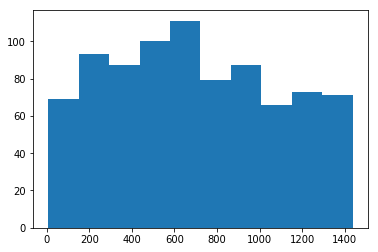

In [10]:
plt.hist(success_times)
plt.show()

In [11]:
print(len(femtimess))
#print(femtimess)
fts = [item for sublist in femtimess for item in sublist]
print(len(fts))

100
1475
